# GNNs

## GNNs with StatQuest

In [14]:
from typing import Any

import torch
import torch.nn as nn
import torch.nn.functional as F
from mpmath.identification import transforms
from pytorch_lightning.utilities.types import OptimizerLRScheduler
from torch.optim import SGD
import matplotlib.pyplot as plt
import seaborn as sns
import pytorch_lightning as L
from torch.utils.data import DataLoader


In [ ]:
class BasicNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.w00 = nn.Parameter(torch.tensor(1.7), requires_grad=False)
        self.b00 = nn.Parameter(torch.tensor(1.7), requires_grad=False)
        self.w11 = nn.Parameter(torch.tensor(1.7), requires_grad=False)

    def forward(self, x):


In [ ]:
# create optimiizer
optimizer = SGD(model.parameters(), lr=0.01)

# for loop for gradient descent
for epoch in range(100):
    total_loss = 0
    for iteration in range(len(inputs)):
        input_i = inputs[iteration]
        label_i = labels[iteration]

        output_i = model(input_i)
        loss = (output_i - labels_i)**2
        loss.backward()
        total_loss += float(loss)

    if total_loss < 0.0001:
        print("num steps: ", epoch)
        break
    optimizer.step()
    optimizer.zero_grad() # without this, would add new derivative to the derivatives of the previous loop
print(f"total loss: {total_loss}, final bias: ")

In [ ]:
class BasicLight(L.LightningModule):
    def __init__(self):
        super.__init__()
        self.w00 = nn.Parameter(torch.tensor(1.7), requires_grad=False)
        self.b00 = nn.Parameter(torch.tensor(1.7), requires_grad=False)
        self.w11 = nn.Parameter(torch.tensor(1.7), requires_grad=False)

        #new!
        self.learning_rate = 0.01
    def forward(self, input)
        input_to_top_relu = input * self.w00 + self.b00
        #...
    def configure_optimizers(self) -> OptimizerLRScheduler:
        return SGD(self.parameters(), lr=self.learning_rate)

    def training_step(self, batch, batch_idx):
        input_i, label_i = batch
        output_i = self.forward(input_i)
        loss = (output_i - label_i)**2
        return loss


In [ ]:
# wrap training data in dataloader!
dataset = TensorDataset(inputs, labels)
dataloader = DataLoader(dataset)
#easier access for batches, possibility to shuffle data each epoch, easy for small fraction of data for debugging

In [ ]:
model = BasicLight()
trainer = L.Trainer(max_epochs=34)
trainer.fit(model, dataloader) # automatically calls zero_grad, backward, optimizer.step; then calls training_step again!

In [ ]:
# gpu accelerator

## GNN with Planetoid - translate into Lightning

In [45]:
from torch_geometric.datasets import Planetoid
from torch_geometric.loader import DataLoader
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import pytorch_lightning as L

In [46]:
dataset = Planetoid(root="tutorial1", name="Cora")
train_loader = DataLoader(dataset, batch_size=15, shuffle=True)
print(len(dataset))
print(dataset.data.num_nodes)
print(dataset.num_node_features)
print(dataset.data)
print(dataset.data.y)
data = dataset[0]
print(next(iter(train_loader)))

1
2708
1433
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
tensor([3, 4, 4,  ..., 3, 3, 3])
DataBatch(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], batch=[2708], ptr=[2])


In [47]:
print(train_loader.dataset)
dataset.num_node_features

Cora()


1433

In [48]:
class GCN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index, y, train_mask, val_mask, test_mask = data.x, data.edge_index, data.y, data.train_mask, data.val_mask, data.test_mask

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

NameError: name 'nn' is not defined

In [113]:
model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

In [138]:
model.eval()
pred = model(data).argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())
print(f'Accuracy: {acc:.4f}')
pred

AttributeError: 'tuple' object has no attribute 'argmax'

### Lightning approach
- optimizes learning rate
- simplifies the training loops
- TPU and GPU approach

Possibilities to change: DataModule (instead of lists use Datasets?)

In [49]:
class LightNN(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index, edge_attr, batch_id = data.x, data.edge_index, data.edge_attr, data.batch

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

    def training_step(self, batch, batch_idx):
        loss, output, y = self._common_step(batch, batch_idx)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, output, y = self._common_step(batch, batch_idx)
        return loss

    def test_step(self, batch, batch_idx):
        loss, output, y = self._common_step(batch, batch_idx)
        return loss

    def _common_step(self, batch, batch_idx):
        output = self.forward(batch)
        loss = F.nll_loss(output, batch.y)
        return loss, output, batch.y

    def configure_optimizers(self):
        return torch.optim.Adam(model.parameters(), lr=0.01)





In [43]:
train_loader

In [50]:
model = LightNN()
trainer = L.Trainer(max_epochs=34)
trainer.fit(model, train_loader)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type    | Params | Mode 
------------------------------------------
0 | conv1 | GCNConv | 22.9 K | train
1 | conv2 | GCNConv | 119    | train
------------------------------------------
23.1 K    Trainable params
0         Non-trainable params
23.1 K    Total params
0.092     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 33: 100%|██████████| 1/1 [00:00<00:00, 81.08it/s, v_num=10] 

`Trainer.fit` stopped: `max_epochs=34` reached.


Epoch 33: 100%|██████████| 1/1 [00:00<00:00, 50.76it/s, v_num=10]


## GNN simple example
https://www.youtube.com/watch?v=sozkSRE8wyc

In [26]:
import torch
from torch_geometric.datasets import KarateClub
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from torch.nn import Linear
from torch_geometric.nn import GCNConv
import pandas as pd

In [28]:
dataset = KarateClub()
data = dataset[0]
loader = DataLoader(dataset, batch_size=10, shuffle=True)
data
print(next(iter(loader)))

DataBatch(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34], batch=[34], ptr=[2])


In [99]:
node_features_df = pd.DataFrame(data.x.numpy(), columns=[f'feature{i}' for i in range(data.x.shape[1])])
node_features_df['node'] = node_features_df.index
node_features_df.set_index('node', inplace=True)

edge_index_df = pd.DataFrame(data.edge_index.numpy().T, columns=['source', 'target'])

labels_df = pd.DataFrame(data.y.numpy(), columns=['label'])
labels_df['node'] = labels_df.index
labels_df.set_index('node', inplace=True)

In [14]:
print(node_features_df.shape)

(34, 34)


In [23]:
print(labels_df)

      label
node       
0         1
1         1
2         1
3         1
4         3
5         3
6         3
7         1
8         0
9         1
10        3
11        1
12        1
13        1
14        0
15        0
16        3
17        1
18        0
19        1
20        0
21        1
22        0
23        0
24        2
25        2
26        0
27        0
28        2
29        0
30        0
31        2
32        0
33        0


In [13]:
num_countries = 4
np.random.seed(42)
countries = torch.tensor(np.random.choice(num_countries, data.num_nodes))
data.y = countries

In [22]:
print(data.y)

tensor([2, 3, 0, 2, 2, 3, 0, 0, 2, 1, 2, 2, 2, 2, 3, 0, 3, 3, 3, 2, 1, 0, 1, 3,
        3, 1, 1, 1, 3, 3, 0, 0, 3, 1])


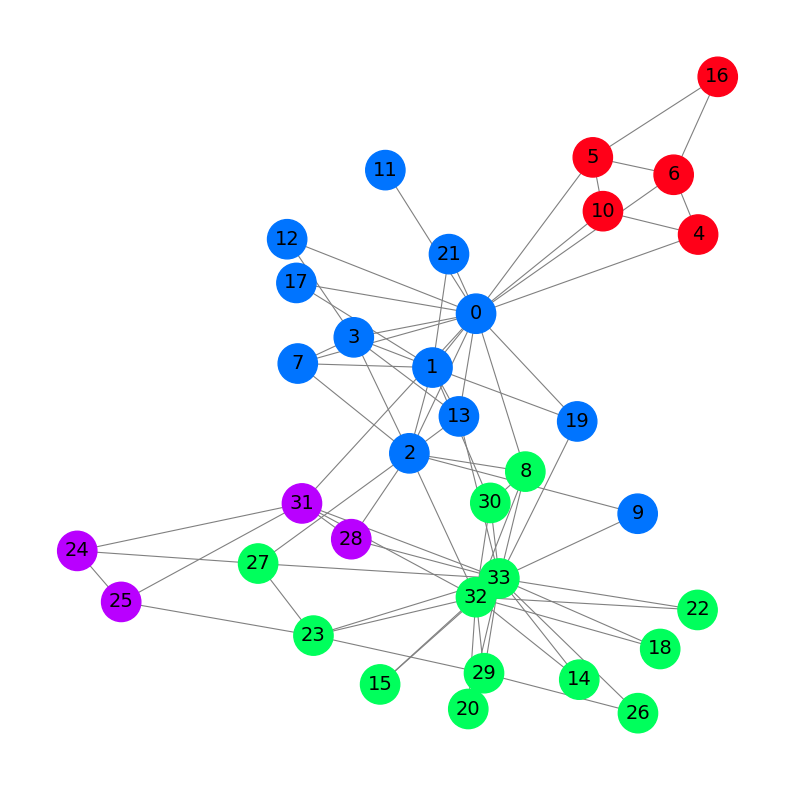

In [29]:
G = to_networkx(data, to_undirected=True)
plt.figure(figsize=(10, 10))
plt.axis('off')
nx.draw_networkx(G,
                 pos = nx.spring_layout(G,seed=0),
                 with_labels = True,
                 node_size = 800,
                 node_color = data.y,
                 cmap="hsv",
                 vmin=-2,
                 vmax=3,
                 width=0.8,
                 edge_color="grey",
                 font_size=14,
                 )
plt.show()

In [30]:
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.gcn = GCNConv(dataset.num_node_features, 3)
        self.out = Linear(3, num_countries)

    def forward(self, x, edge_index):

        h = self.gcn(x, edge_index).relu()
        z = self.out(h)
        return h, z

model = GCN()
print(model)

GCN(
  (gcn): GCNConv(34, 3)
  (out): Linear(in_features=3, out_features=4, bias=True)
)


In [31]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.02)
def accuracy(pred_y, y):
    return (pred_y==y).sum()/len(y)


In [32]:
embeddings = []
losses = []
accuracies = []
outputs = []

for epoch in range(200):
    optimizer.zero_grad()
    h, z = model(data.x, data.edge_index)
    loss = criterion(z, data.y)
    acc = accuracy(z.argmax(dim=1), data.y)
    loss.backward()
    optimizer.step()
    embeddings.append(h)
    losses.append(loss)
    accuracies.append(acc)
    outputs.append(z.argmax(dim=1))
    if epoch % 10 == 0:
        print(f'Epoch {epoch:>3} | Loss: {loss:.2f} | Accuracy: {acc*100:.2f}%')

Epoch   0 | Loss: 1.34 | Accuracy: 38.24%
Epoch  10 | Loss: 1.15 | Accuracy: 52.94%
Epoch  20 | Loss: 0.91 | Accuracy: 70.59%
Epoch  30 | Loss: 0.66 | Accuracy: 94.12%
Epoch  40 | Loss: 0.44 | Accuracy: 97.06%
Epoch  50 | Loss: 0.30 | Accuracy: 100.00%
Epoch  60 | Loss: 0.20 | Accuracy: 100.00%
Epoch  70 | Loss: 0.14 | Accuracy: 100.00%
Epoch  80 | Loss: 0.10 | Accuracy: 100.00%
Epoch  90 | Loss: 0.08 | Accuracy: 100.00%
Epoch 100 | Loss: 0.06 | Accuracy: 100.00%
Epoch 110 | Loss: 0.05 | Accuracy: 100.00%
Epoch 120 | Loss: 0.04 | Accuracy: 100.00%
Epoch 130 | Loss: 0.03 | Accuracy: 100.00%
Epoch 140 | Loss: 0.03 | Accuracy: 100.00%
Epoch 150 | Loss: 0.03 | Accuracy: 100.00%
Epoch 160 | Loss: 0.02 | Accuracy: 100.00%
Epoch 170 | Loss: 0.02 | Accuracy: 100.00%
Epoch 180 | Loss: 0.02 | Accuracy: 100.00%
Epoch 190 | Loss: 0.02 | Accuracy: 100.00%


### Lightning

In [39]:
class GCNN(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.gcn = GCNConv(dataset.num_node_features, 3)
        self.out = Linear(3, num_countries)

    def forward(self, data):
        x, edge_index, edge_attr, batch_id = data.x, data.edge_index, data.edge_attr, data.batch
        h = self.gcn(x, edge_index).relu()
        z = self.out(h)
        return h, z

    def training_step(self, batch, batch_idx):
        #x, y = batch
        h, z = self.forward(batch)
        loss = criterion(z, batch.y)
        return loss

    def validation_step(self, batch, batch_idx):
        #x, y = batch
        h, z = self.forward(batch)
        loss = criterion(z, batch.y)
        return loss

    def test_step(self, batch, batch_idx):
        #x, y = batch
        h, z = self.forward(batch)
        loss = criterion(z, batch.y)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(model.parameters(), lr=0.01)


model = GCNN()
print(model)

GCNN(
  (gcn): GCNConv(34, 3)
  (out): Linear(in_features=3, out_features=4, bias=True)
)


In [40]:
trainer = L.Trainer(max_epochs=200)
trainer.fit(model, loader)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | gcn  | GCNConv | 105    | train
1 | out  | Linear  | 16     | train
-----------------------------------------
121       Trainable params
0         Non-trainable params
121       Total params
0.000     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode


Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 64.84it/s, v_num=8] 

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 42.18it/s, v_num=8]


## GAT Layer - implementation example
https://colab.research.google.com/github/AntonioLonga/PytorchGeometricTutorial/blob/main/Tutorial3/Tutorial3.ipynb#scrollTo=zpewr24l2aVp

In [42]:
import os

# For downloading pre-trained models
import urllib.request
from urllib.error import HTTPError

# PyTorch Lightning
import pytorch_lightning as pl

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# PyTorch geometric
import torch_geometric
import torch_geometric.data as geom_data
import torch_geometric.nn as geom_nn

# PL callbacks
from pytorch_lightning.callbacks import ModelCheckpoint
from torch import Tensor

In [69]:
class GATLayer(nn.Module):
    def __init__(self, in_features, out_features, dropout, alpha, concat=True):
        super(GATLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.dropout = dropout
        self.alpha = alpha
        self.concat = concat

        # xavier initialisation of weights
        self.W = nn.Parameter(torch.zeros(size=(in_features, out_features)))
        nn.init.xavier_uniform_(self.W.data, gain=1.414)

        self.a = nn.Parameter(torch.zeros(size=(2*out_features, 1)))
        nn.init.xavier_uniform_(self.a.data, gain=1.414)

        self.leakyrelu = nn.LeakyReLU(self.alpha)

    def forward(self, input, adj): # forward method takes input and adj
        h = torch.mm(input, self.W)
        N = h.size()[0]
        print(N)

        # Attention Mechanism
        a_input = torch.cat([h.repeat(1, N).view(N * N, -1), h.repeat(N, 1)], dim=1).view(N, -1, 2 * self.out_features)
        e = leakyrelu(torch.matmul(a_input, self.a).squeeze(2))

        # Masked Attention
        zero_vec  = -9e15*torch.ones_like(e)
        attention = torch.where(adj > 0, e, zero_vec)
        attention = F.softmax(attention, dim=1)
        attention = F.dropout(attention, self.dropout, training=self.training)
        h_prime   = torch.matmul(attention, h)

        if self.concat:
            return F.elu(h_prime)
        else:
            return h_prime


#### Basics

In [53]:
in_features = 5
out_features = 2
nb_nodes = 3

W = nn.Parameter(torch.zeros(size=(in_features, out_features))) #xavier paramiter inizializator => why do we need to initiliase using xavier?
nn.init.xavier_uniform_(W.data, gain=1.414)

input = torch.rand(nb_nodes,in_features)

print(input)
print(W)
# linear transformation
h = torch.mm(input, W)
N = h.size()[0]

print(h.shape)
print(h)
print(N)


tensor([[0.8659, 0.5889, 0.1710, 0.7384, 0.4178],
        [0.8482, 0.4836, 0.2142, 0.4005, 0.6425],
        [0.3311, 0.8723, 0.6998, 0.0364, 0.9427]])
Parameter containing:
tensor([[-0.1829, -0.8750],
        [ 0.3144, -1.0069],
        [-1.3085, -0.0132],
        [-0.1048,  0.8033],
        [ 0.0761, -1.1515]], requires_grad=True)
torch.Size([3, 2])
tensor([[-0.2426, -1.2409],
        [-0.2765, -1.6501],
        [-0.6341, -2.2335]], grad_fn=<MmBackward0>)
3
tensor([[-0.2426, -1.2409],
        [-0.2426, -1.2409],
        [-0.2426, -1.2409],
        [-0.2765, -1.6501],
        [-0.2765, -1.6501],
        [-0.2765, -1.6501],
        [-0.6341, -2.2335],
        [-0.6341, -2.2335],
        [-0.6341, -2.2335]], grad_fn=<ViewBackward0>)
tensor([[-0.2426, -1.2409],
        [-0.2765, -1.6501],
        [-0.6341, -2.2335],
        [-0.2426, -1.2409],
        [-0.2765, -1.6501],
        [-0.6341, -2.2335],
        [-0.2426, -1.2409],
        [-0.2765, -1.6501],
        [-0.6341, -2.2335]], grad_f

In [54]:
print(h.repeat(1, N).view(N * N, -1))
print(h.repeat(N, 1))
print(torch.cat([h.repeat(1, N).view(N * N, -1), h.repeat(N, 1)], dim=1))
print(torch.cat([h.repeat(1, N).view(N * N, -1), h.repeat(N, 1)], dim=1).view(N, -1, 2 * out_features))

tensor([[-0.2426, -1.2409],
        [-0.2426, -1.2409],
        [-0.2426, -1.2409],
        [-0.2765, -1.6501],
        [-0.2765, -1.6501],
        [-0.2765, -1.6501],
        [-0.6341, -2.2335],
        [-0.6341, -2.2335],
        [-0.6341, -2.2335]], grad_fn=<ViewBackward0>)
tensor([[-0.2426, -1.2409],
        [-0.2765, -1.6501],
        [-0.6341, -2.2335],
        [-0.2426, -1.2409],
        [-0.2765, -1.6501],
        [-0.6341, -2.2335],
        [-0.2426, -1.2409],
        [-0.2765, -1.6501],
        [-0.6341, -2.2335]], grad_fn=<RepeatBackward0>)
tensor([[-0.2426, -1.2409, -0.2426, -1.2409],
        [-0.2426, -1.2409, -0.2765, -1.6501],
        [-0.2426, -1.2409, -0.6341, -2.2335],
        [-0.2765, -1.6501, -0.2426, -1.2409],
        [-0.2765, -1.6501, -0.2765, -1.6501],
        [-0.2765, -1.6501, -0.6341, -2.2335],
        [-0.6341, -2.2335, -0.2426, -1.2409],
        [-0.6341, -2.2335, -0.2765, -1.6501],
        [-0.6341, -2.2335, -0.6341, -2.2335]], grad_fn=<CatBackward0>)
ten

In [58]:
a = nn.Parameter(torch.zeros(size=(2*out_features, 1))) #xavier paramiter inizializator
nn.init.xavier_uniform_(a.data, gain=1.414)
print(a.shape)

leakyrelu = nn.LeakyReLU(0.2)  # LeakyReLU
a

torch.Size([4, 1])


Parameter containing:
tensor([[ 1.5459],
        [-1.2327],
        [-0.2090],
        [ 0.9252]], requires_grad=True)

In [50]:
a_input = torch.cat([h.repeat(1, N).view(N * N, -1), h.repeat(N, 1)], dim=1).view(N, -1, 2 * out_features) # all possible combinations

In [63]:
e = leakyrelu(torch.matmul(a_input, a))
print(e)
print(e.shape)
e = leakyrelu(torch.matmul(a_input, a).squeeze(2))
print(e)
print(e.shape)
# a and e computed for entire graph => mask attention (only for neighboring)

tensor([[[-0.1637],
         [-0.2782],
         [-0.0410]],

        [[ 1.8765],
         [ 1.3044],
         [ 2.4900]],

        [[-0.4299],
         [-0.5443],
         [-0.3072]]], grad_fn=<LeakyReluBackward0>)
torch.Size([3, 3, 1])
tensor([[-0.1637, -0.2782, -0.0410],
        [ 1.8765,  1.3044,  2.4900],
        [-0.4299, -0.5443, -0.3072]], grad_fn=<LeakyReluBackward0>)
torch.Size([3, 3])


In [64]:
print(a_input.shape,a.shape)
print("")
print(torch.matmul(a_input,a).shape)
print("")
print(torch.matmul(a_input,a).squeeze(2).shape)

torch.Size([3, 3, 4]) torch.Size([4, 1])

torch.Size([3, 3, 1])

torch.Size([3, 3])


In [67]:
# Masked Attention
adj = torch.randint(2, (3, 3))

zero_vec  = -9e15*torch.ones_like(e)
print(zero_vec.shape)
attention = torch.where(adj > 0, e, zero_vec)
print(adj,"\n",e,"\n",zero_vec)
attention

torch.Size([3, 3])
tensor([[0, 1, 0],
        [1, 1, 0],
        [0, 1, 1]]) 
 tensor([[-0.1637, -0.2782, -0.0410],
        [ 1.8765,  1.3044,  2.4900],
        [-0.4299, -0.5443, -0.3072]], grad_fn=<LeakyReluBackward0>) 
 tensor([[-9.0000e+15, -9.0000e+15, -9.0000e+15],
        [-9.0000e+15, -9.0000e+15, -9.0000e+15],
        [-9.0000e+15, -9.0000e+15, -9.0000e+15]])


tensor([[-9.0000e+15, -2.7815e-01, -9.0000e+15],
        [ 1.8765e+00,  1.3044e+00, -9.0000e+15],
        [-9.0000e+15, -5.4426e-01, -3.0715e-01]], grad_fn=<WhereBackward0>)

In [68]:
attention = F.softmax(attention, dim=1)
h_prime   = torch.matmul(attention, h)
attention

tensor([[0.0000, 1.0000, 0.0000],
        [0.6392, 0.3608, 0.0000],
        [0.0000, 0.4410, 0.5590]], grad_fn=<SoftmaxBackward0>)